In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from PIL import Image
from models.vision_language_model import VisionLanguageModel
from data.processors import get_tokenizer, get_image_processor, get_image_string

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

klein_blue_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "white_to_klein", 
    ["white", "#002FA7"]
)

In [3]:
# --- 1. Configuration ---
# Set your parameters here
MODEL_HF_REPO = "lusxvr/nanoVLM"
IMAGE_PATH = "assets/puppy_lab.png"
PROMPT = "What is the name of the dog’s toy?"
MAX_NEW_TOKENS = 10

In [4]:
# --- 2. Setup Device and Seed ---
print("Setting up device and seed...")
torch.manual_seed(0)
device = "mps"
print(f"Using device: {device}")

Setting up device and seed...
Using device: mps


In [5]:
# --- 3. Load Model ---
print(f"Loading model from: {MODEL_HF_REPO}")
# Load the model from HuggingFace (or a local path) and move to device
model = VisionLanguageModel.from_pretrained(MODEL_HF_REPO).to(device)
_ = model.eval()  # Set model to evaluation mode

Loading model from: lusxvr/nanoVLM


In [6]:
# --- 4. Load Tokenizer and Image Processor ---
print("Loading tokenizer and image processor...")
# Get the tokenizer from the model's configuration
tokenizer = get_tokenizer(
    model.cfg.lm_tokenizer, 
    model.cfg.vlm_extra_tokens, 
    model.cfg.lm_chat_template
)

# Get the image processor from the model's configuration
resize_to_max_side_len = getattr(model.cfg, "resize_to_max_side_len", False)
image_processor = get_image_processor(
    model.cfg.max_img_size, 
    model.cfg.vit_img_size, 
    resize_to_max_side_len
)

Loading tokenizer and image processor...
Resize to max side len: True


Loading and processing image: assets/puppy_lab.png


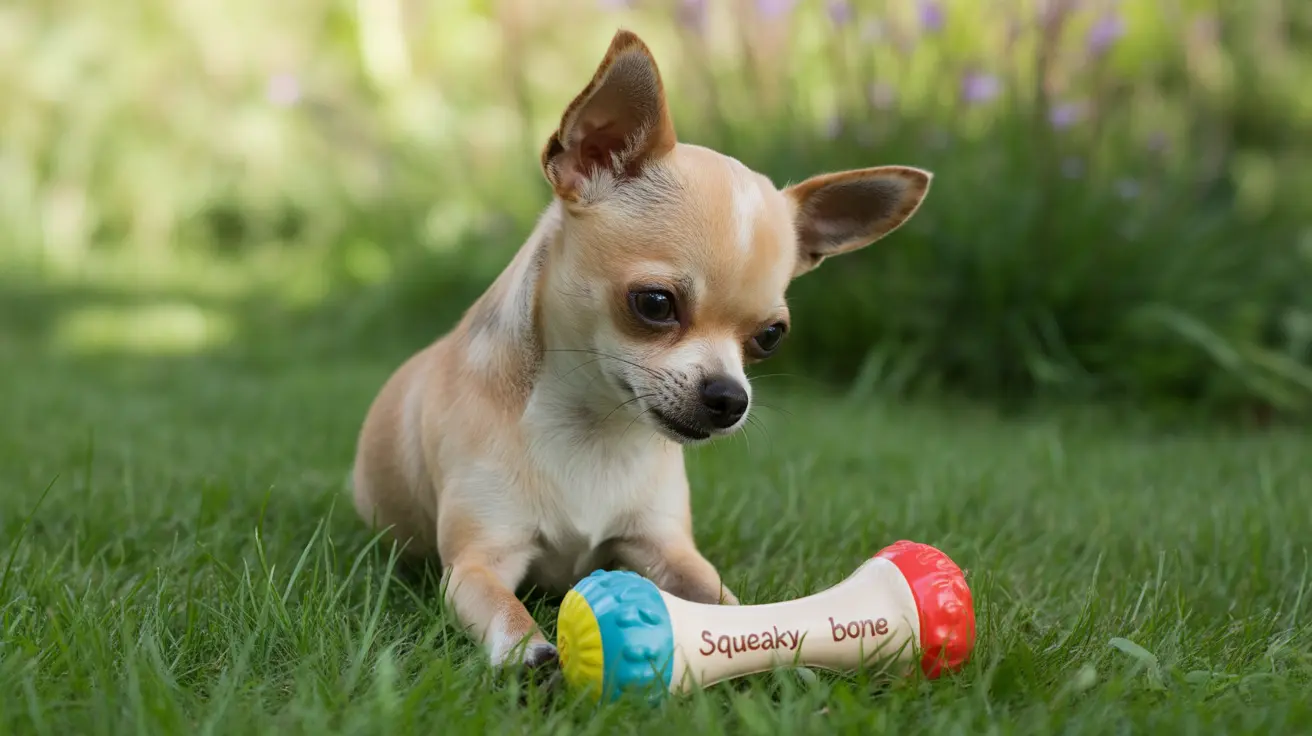

In [11]:
# --- 5. Load and Process Image ---
print(f"Loading and processing image: {IMAGE_PATH}")
# Open the image using PIL
img = Image.open(IMAGE_PATH).convert("RGB")

img

In [8]:
# Process the image into tensors and get its grid-like structure (splitted_image_ratio)
processed_image, splitted_image_ratio = image_processor(img)

# Handle models that don't have a global image token
if not hasattr(tokenizer, "global_image_token") and \
   splitted_image_ratio[0] * splitted_image_ratio[1] == len(processed_image) - 1:
    processed_image = processed_image[1:]

# Move the final image tensor to the device
image_tensor = processed_image.to(device)

In [12]:
image_tensor.shape

torch.Size([13, 3, 512, 512])

In [9]:
def find_first_and_last(my_list, target):
    """
    Finds the first and last index of a target item in a list.

    Args:
        my_list (list): The list to search in.
        target: The item to search for.

    Returns:
        tuple: (first_index, last_index) or (None, None) if not found.
    """
    first_index = None
    last_index = None

    # Find the first occurrence
    try:
        first_index = my_list.index(target)
    except ValueError:
        # The target was not found in the list at all
        return (None, None)

    # Find the last occurrence by searching backward
    # We start from the end of the list and go down to 0
    for i in range(len(my_list) - 1, -1, -1):
        if my_list[i] == target:
            last_index = i
            break  # Stop as soon as we find the last one

    return (first_index, last_index)

# --- 6. Prepare Text Prompt ---
print(f"Preparing prompt: \"{PROMPT}\"")
# Get the special image string (e.g., "<image><image>...<image>")
image_string = get_image_string(
    tokenizer, 
    [splitted_image_ratio], 
    model.cfg.mp_image_token_length
)

# Format the prompt using the model's chat template
messages = [{"role": "user", "content": image_string + PROMPT}]
encoded_prompt = tokenizer.apply_chat_template(
    [messages], 
    tokenize=True, 
    add_generation_prompt=True
)

# Convert the tokenized prompt to a tensor on the device
prompt_tokens = torch.tensor(encoded_prompt).to(device)

Preparing prompt: "What is the name of the dog’s toy?"


In [58]:
encoded_prompt

[[1,
  4093,
  198,
  49153,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49154,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,
  49152,

In [31]:
tokenized_input = [tokenizer.decode(t) for t in encoded_prompt[0]]

image_si, image_ei = find_first_and_last(tokenized_input, "<|image|>")
global_image_si, global_image_ei = image_si, image_si+65
text_si, text_ei = image_ei + 1, tokenized_input.index("<|im_end|>") - 1

tokenized_input[text_ei]

'?'

In [12]:
# --- 7. Generate Response ---
print("\nGenerating response...")
# Run generation in a no_grad context to save memory
with torch.no_grad():
    generated_ids = model.generate(
        prompt_tokens, 
        image_tensor, 
        max_new_tokens=MAX_NEW_TOKENS
    )

# --- 8. Decode and Print Output ---
# Decode the generated token IDs back into a text string
output = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

print("\n--- Model Output ---")
print(output)
print("--------------------")


Generating response...

--- Model Output ---
Squeaky bone
--------------------


In [ ]:
class SimpleHook:
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn, with_kwargs=True)

    def hook_fn(self, module, args, kwargs, output):
        self.args = args
        self.kwargs = kwargs
        self.output = output

hook = SimpleHook(model.decoder.blocks[10].attn.attn_dropout)

with torch.no_grad():
    generated_ids = model(
        prompt_tokens, 
        image_tensor, 
    )

In [52]:
prompt_tokens.shape, image_tensor.shape

(torch.Size([1, 865]), torch.Size([13, 3, 512, 512]))

In [29]:
attns = hook.args[0]
attns = attns.squeeze()
attns = attns.cpu()

attns = attns[3].T

attns.shape, attns.min(), attns.max()

(torch.Size([865, 865]), tensor(0.), tensor(1.))

In [37]:
tokenized_input = [tokenizer.decode(t) for t in encoded_prompt[0]]

image_si, image_ei = find_first_and_last(tokenized_input, "<|image|>")
global_image_si, global_image_ei = image_si, image_si+64
text_si, text_ei = image_ei + 1, tokenized_input.index("<|im_end|>")

tokenized_input[text_ei]

'<|im_end|>'

In [51]:
attns[global_image_si:global_image_ei, text_si:text_ei].max()

tensor(0.0047)

In [ ]:
global_image_si,global_image_ei, text_si,text_ei

(4, 68, 848, 859)

In [65]:
attns[global_image_si:global_image_ei, text_si:text_ei].T[0,:]

tensor([4.3274e-05, 4.8877e-06, 2.6005e-05, 7.8478e-06, 1.3094e-05, 5.7568e-07,
        2.7788e-05, 2.4048e-04, 1.5863e-04, 6.5419e-06, 1.0482e-05, 9.8967e-07,
        2.9629e-06, 3.8764e-06, 1.8050e-05, 1.1944e-04, 1.2301e-05, 1.1569e-05,
        5.8961e-05, 4.8163e-05, 6.9634e-05, 1.1715e-05, 1.2251e-05, 2.1057e-05,
        8.2386e-06, 2.0065e-05, 1.6496e-05, 1.1938e-05, 3.0539e-05, 1.6026e-05,
        1.2377e-05, 4.5272e-05, 5.0793e-05, 1.0148e-05, 2.6661e-05, 4.1565e-05,
        5.8540e-06, 2.3139e-06, 3.6691e-06, 5.1577e-06, 3.5010e-06, 4.8411e-06,
        7.0353e-06, 3.6171e-05, 1.3039e-05, 9.7451e-06, 1.4945e-05, 3.3117e-05,
        1.4702e-05, 9.3096e-06, 6.6495e-06, 7.4388e-06, 4.5404e-06, 7.9633e-06,
        3.2633e-06, 2.4928e-05, 5.7023e-05, 2.3883e-05, 2.3342e-06, 1.3842e-05,
        6.6691e-06, 5.8065e-06, 5.4785e-06, 3.3644e-04])

In [61]:
attns[global_image_si:global_image_ei, text_si:text_ei][0,:].shape

torch.Size([11])

In [62]:
attns[global_image_si:global_image_ei, text_si:text_ei].shape

torch.Size([64, 11])

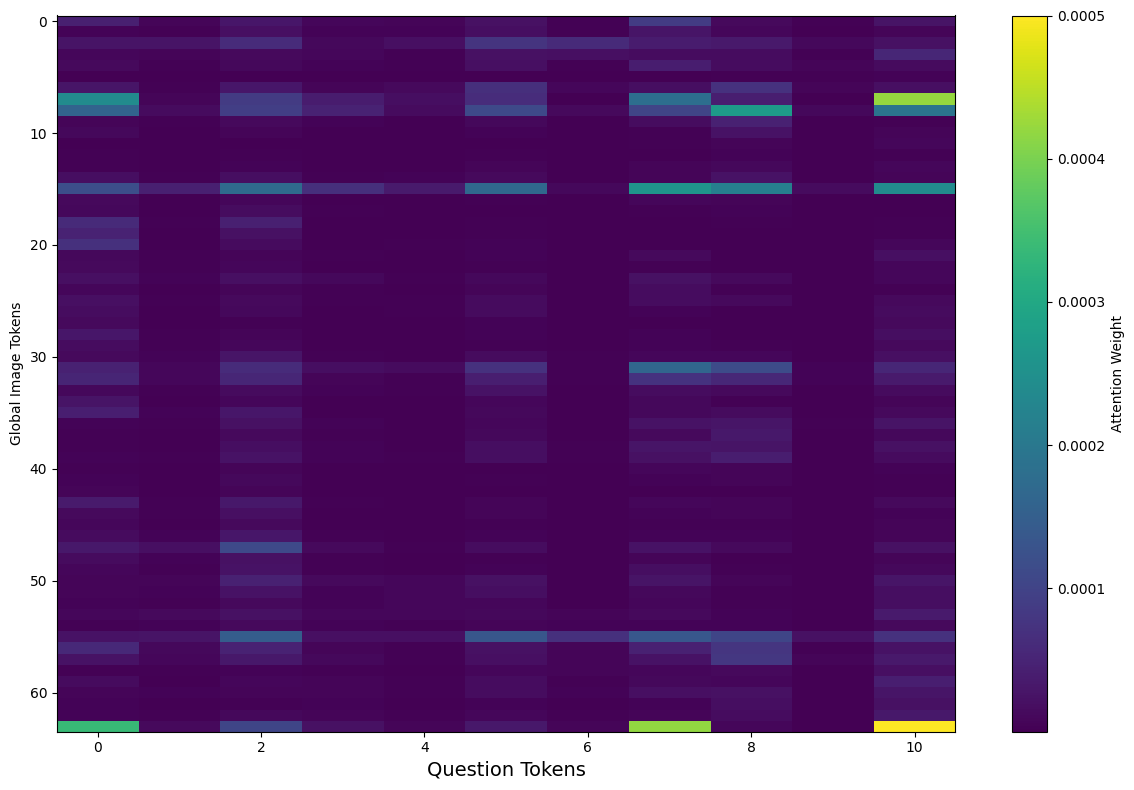

In [50]:
plt.figure(figsize=(12, 8))
plt.imshow(attns[global_image_si:global_image_ei, text_si:text_ei], cmap='viridis', vmax=0.0005, aspect='auto')
# plt.title(f"Layer {layer_idx}, Head {head_idx}: Vision → Question Attention", fontsize=14)
plt.ylabel('Global Image Tokens')
# plt.xticks(range(len(token_labels)), token_labels, rotation=90)
plt.xlabel("Question Tokens", fontsize=14)
plt.colorbar(label="Attention Weight")
plt.tight_layout()
plt.show()

In [57]:
tokenized_input

['<|im_start|>',
 'user',
 '\n',
 '<|global_image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<|image|>',
 '<row_1_col_1>',
 '<|image|>',
 '<|image|>',
 '<|

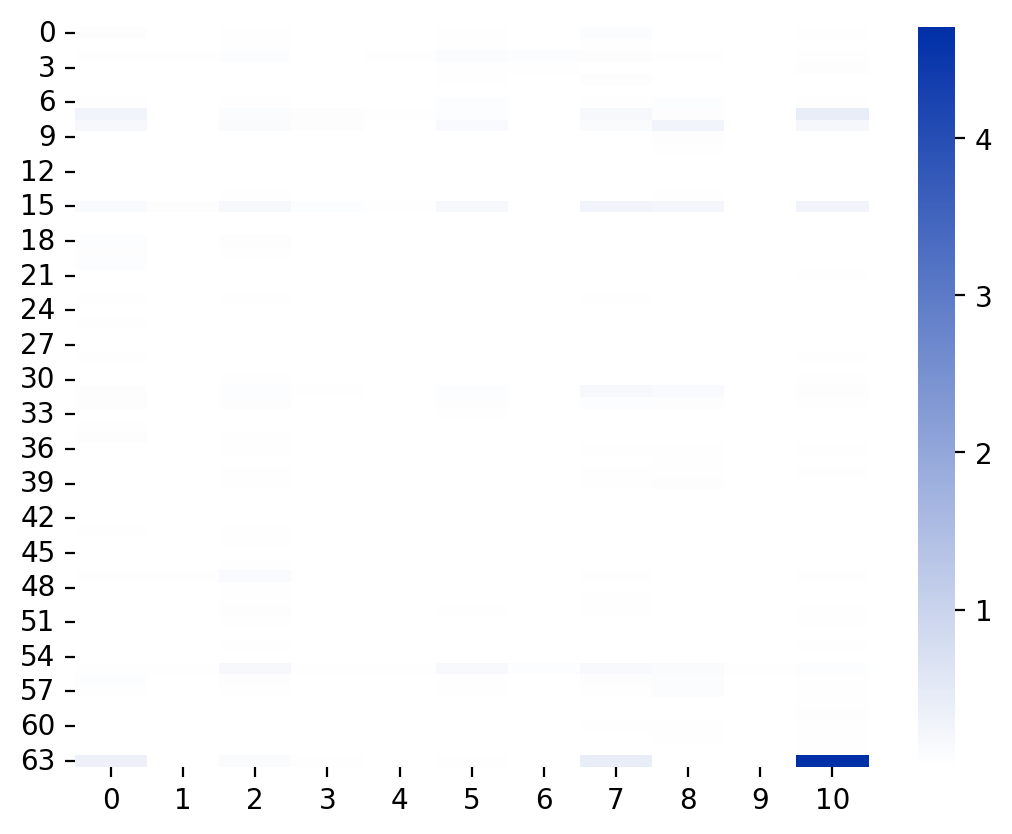

In [ ]:
plt.figure(dpi=200)
sns.heatmap(
    pd.DataFrame(attns[global_image_si:global_image_ei, text_si:text_ei]),
    # annot=True,
    # fmt=".1f",
    cmap=klein_blue_cmap,
)
plt.show()

In [72]:
image_matrix = attns[:, image_si:image_ei+1, image_si:image_ei+1]

image_matrix.shape, image_matrix[3].min(), image_matrix[3].max()

(torch.Size([15, 844, 844]), tensor(0.), tensor(0.9151))

In [73]:
text_matrix = attns[:, text_si:text_ei+1, text_si:text_ei+1]

text_matrix.shape, text_matrix[3].min(), text_matrix[3].max()

(torch.Size([15, 11, 11]), tensor(0.), tensor(0.4014))

In [78]:
global_image_si, global_image_ei

(4, 69)

In [22]:
text_vs_global_image_matrix = attns[4:68, -16:-6]

text_vs_global_image_matrix.shape, text_vs_global_image_matrix.min(), text_vs_global_image_matrix.max()

(torch.Size([64, 10]), tensor(9.7323e-09), tensor(0.0047))

In [76]:
text_vs_global_image_matrix.min(), text_vs_global_image_matrix.max()

(tensor(0.), tensor(0.))

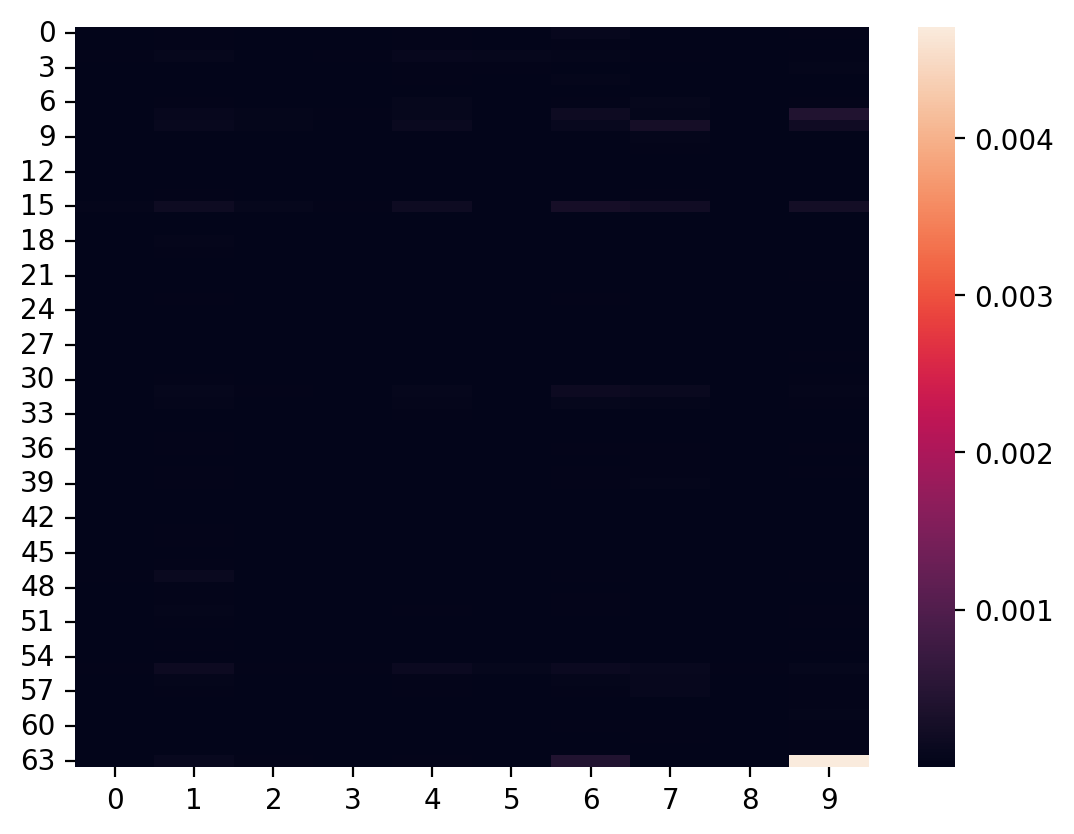

In [25]:
plt.figure(dpi=200)
sns.heatmap(
    pd.DataFrame(text_vs_global_image_matrix),
    # annot=True,
    fmt=".1f",
    # cmap=klein_blue_cmap,
)
plt.show()

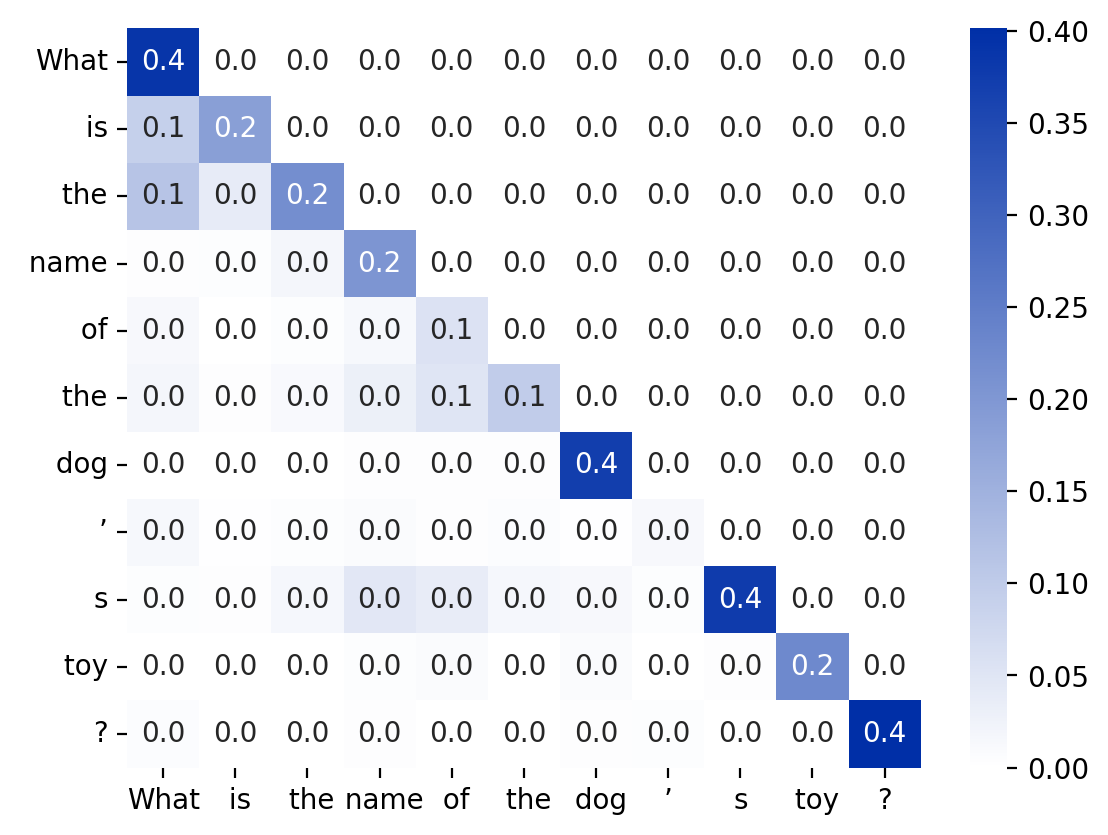

In [89]:
plt.figure(dpi=200)
sns.heatmap(
    pd.DataFrame(text_vs_global_image_matrix[3], index=tokenized_input[text_si:text_ei+1], columns=tokenized_input[text_si:text_ei+1]),
    annot=True,
    fmt=".1f",
    cmap=klein_blue_cmap,
)
plt.show()

In [86]:
len(tokenized_input), attns.shape

(865, torch.Size([15, 865, 865]))

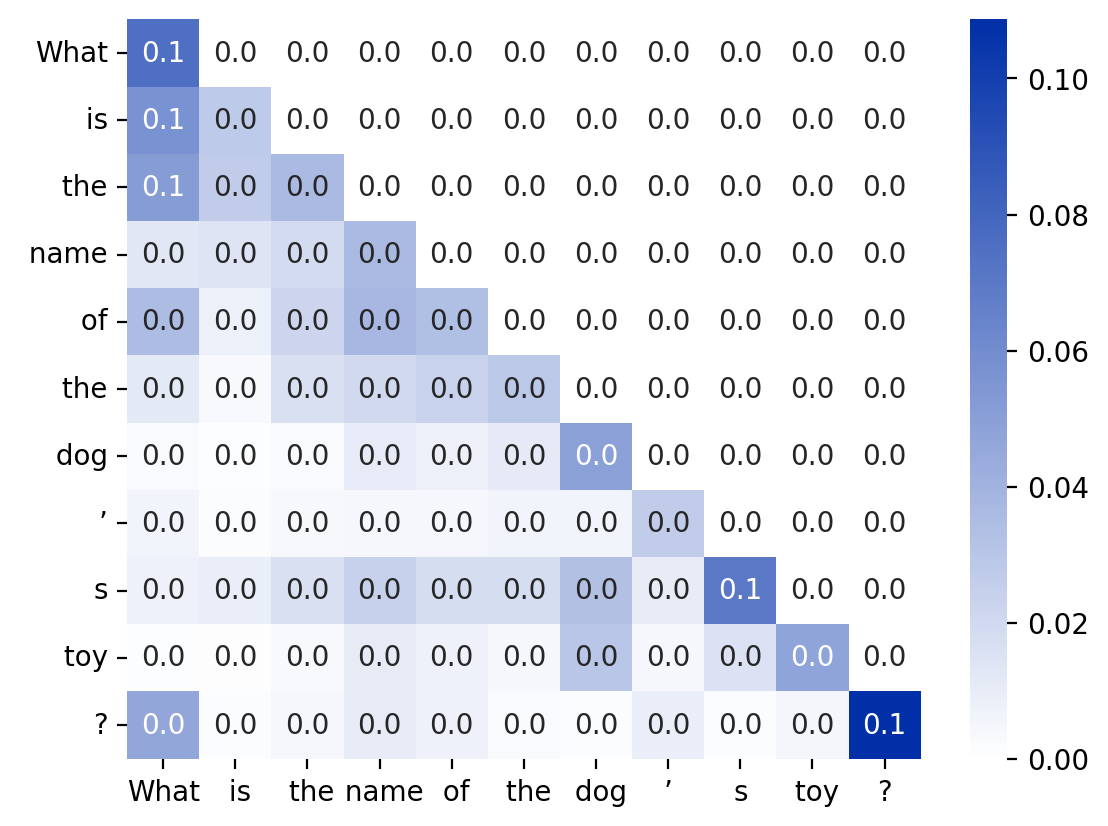

In [ ]:
plt.figure(dpi=200)
sns.heatmap(
    pd.DataFrame(text_matrix.mean(0), index=tokenized_input[text_si:text_ei+1], columns=tokenized_input[text_si:text_ei+1]),
    annot=True,
    fmt=".1f",
    cmap=klein_blue_cmap,
)
plt.show()

In [25]:
text_matrix.min(), text_matrix.max()

(tensor(0.), tensor(0.6954))

In [26]:
text_matrix

tensor([[[1.3583e-03, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.1606e-03, 4.9669e-04, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.9120e-03, 6.8460e-05, 1.9098e-03,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [5.7210e-06, 9.6851e-07, 2.1865e-05,  ..., 2.4890e-02,
          0.0000e+00, 0.0000e+00],
         [7.8095e-09, 3.3090e-09, 9.0423e-08,  ..., 2.6088e-06,
          5.8181e-04, 0.0000e+00],
         [2.1062e-04, 6.5676e-07, 5.1230e-05,  ..., 4.7914e-06,
          4.7138e-07, 2.3812e-02]],

        [[4.4775e-02, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.3383e-02, 5.1180e-03, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [7.1395e-03, 1.0831e-04, 1.1502e-02,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [3.7797e-04, 4.4452e-05, 2.8286e-03,  ..., 3.8763e-02,
          0.000